<a href="https://colab.research.google.com/github/sauvatu/HS-algorithm/blob/master/Chp5_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RNN Implementation**

In [1]:
# common/time_layers.py
import sys
sys.path.append('..')
from common.np import *
from common.layers import *
from common.functions import sigmoid


class RNN:
    def __init__(self, Wx, Wh, b):#Initializes the RNN with parameters: weights for
        self.params = [Wx, Wh, b] #input (Wx), weights for hidden states (Wh), and biases (b).
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None  # Intermediate data to use for backpropagation

#Performs the forward pass of the RNN given input x and previous hidden state h_prev
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

#Computes gradients of parameters and input/output with respect to the loss.
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)  # tanh differential
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)  # shape: (H, N) x (N, H) = (H, H)
        dh_prev = np.dot(dt, Wh.T)  # shape: (N, H) x (H, H) = (N, H)
        dWx = np.dot(x.T, dt)  # shape: (D, N) x (N, H) = (D, H)
        dx = np.dot(dt, Wx.T)  # shape: (N, H) x (H, D) = (N, D)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

Implementation of Time RNN Layer

In [2]:
# common/time_layers.py

#Initializes the TimeRNN with parameters Wx, Wh, and b, along with additional
#attributes for gradients (grads), layers, and hidden state (h)
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None  # RNN Save hierarchy as list

        self.h, self.dh = None, None
        self.stateful = stateful

    def set_state(self, h):
        '''hidden state(h)method to set'''
        self.h = h

    def reset_state(self):
        '''hidden state(h)Method to initialize'''
        self.h = None
#Accepts a sequence of inputs (xs) with shape (N, T, D), where N is the batch
#size, T is the number of time steps, and D is the input size.
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape  # N(batch), T(time steps), D(input size)
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs
#Iterates backward through time steps, retrieves the corresponding RNN layer,
#performs backward pass, and accumulates gradients for parameters (Wx, Wh, b) and input (dxs).
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)  # Summed slope
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

In [3]:
# common/time_layers.py
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

#Accepts a 2D array xs representing a batch of sequences, where each row
#corresponds to a sequence of indices of symbols.
    def forward(self, xs):
        N, T = xs.shape  # N(batch), T(timesteps)
        V, D = self.W.shape  # V(vocab_size), D(embedding_size)

        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):#Updates the grads attribute with the accumulated gradients.
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None

In [4]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params
#Performs the affine transformation on the reshaped input using matrix
#multiplication with W and addition with b.
        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params
#Computes gradients for parameters W and b using matrix multiplication and summation, respectively.
        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx

Time Softmax with Loss

In [5]:
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # When the correct answer label is a one-hot vector
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # Summary of batch and time series use(reshape)
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_labelData corresponding to set loss to 0
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache
        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_labelData corresponding to is set to slope 0

        dx = dx.reshape((N, T, V))

        return dx


# **RNNLM Learning and Assessment**

In [6]:
# chap05/simple_rnnlm.py
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *


class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # weight initialization (Xavier initialization)
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # Create a hierarchy
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b),
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # Collect all weights and gradients in a list.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

RNNLM Learning Code

Corpus size: 1000, number of vocabulary: 418
| 에폭 1 | 퍼플렉서티 390.83
| 에폭 2 | 퍼플렉서티 262.62
| 에폭 3 | 퍼플렉서티 225.47
| 에폭 4 | 퍼플렉서티 214.28
| 에폭 5 | 퍼플렉서티 205.92
| 에폭 6 | 퍼플렉서티 202.21
| 에폭 7 | 퍼플렉서티 198.93
| 에폭 8 | 퍼플렉서티 196.22
| 에폭 9 | 퍼플렉서티 191.27
| 에폭 10 | 퍼플렉서티 192.76
| 에폭 11 | 퍼플렉서티 188.51
| 에폭 12 | 퍼플렉서티 192.06
| 에폭 13 | 퍼플렉서티 189.18
| 에폭 14 | 퍼플렉서티 189.81
| 에폭 15 | 퍼플렉서티 188.71
| 에폭 16 | 퍼플렉서티 185.58
| 에폭 17 | 퍼플렉서티 182.87
| 에폭 18 | 퍼플렉서티 179.14
| 에폭 19 | 퍼플렉서티 180.17
| 에폭 20 | 퍼플렉서티 181.13
| 에폭 21 | 퍼플렉서티 179.76
| 에폭 22 | 퍼플렉서티 175.18
| 에폭 23 | 퍼플렉서티 173.45
| 에폭 24 | 퍼플렉서티 174.29
| 에폭 25 | 퍼플렉서티 171.54
| 에폭 26 | 퍼플렉서티 170.85
| 에폭 27 | 퍼플렉서티 165.19
| 에폭 28 | 퍼플렉서티 163.36
| 에폭 29 | 퍼플렉서티 161.74
| 에폭 30 | 퍼플렉서티 153.86
| 에폭 31 | 퍼플렉서티 155.76
| 에폭 32 | 퍼플렉서티 149.15
| 에폭 33 | 퍼플렉서티 150.77
| 에폭 34 | 퍼플렉서티 145.16
| 에폭 35 | 퍼플렉서티 143.17
| 에폭 36 | 퍼플렉서티 138.67
| 에폭 37 | 퍼플렉서티 134.14
| 에폭 38 | 퍼플렉서티 128.86
| 에폭 39 | 퍼플렉서티 124.68
| 에폭 40 | 퍼플렉서티 119.23
| 에폭 41 | 퍼플렉서티 120.49
| 에폭 42 | 퍼플렉서티 112.4

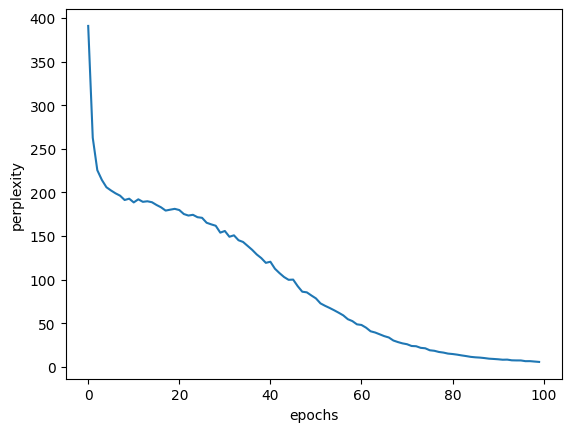

In [7]:
%matplotlib inline
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from simple_rnnlm import SimpleRnnlm


#Hyper-parameter settings
batch_size = 10
wordvec_size = 100
hidden_size = 100 #Number of elements in the hidden state vector of RNN
time_size = 5     # Truncated BPTT-The amount of time that unfolds at once
lr = 0.1
max_epoch = 100

# Read training data (only 1000 of total)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # input
ts = corpus[1:]   # Output (answer label)
data_size = len(xs)
print('Corpus size: %d, number of vocabulary: %d' % (corpus_size, vocab_size))

# Variables used during learning
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# Model creation
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# Calculate the read start position of each sample in the minibatch
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # Mini-batch acquisition
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # Update parameters by finding slope
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # Perplexity evaluation per epoch
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# drawing graphs
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 417.88
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 403.09
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 304.48
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 233.40
| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 215.51
| 에폭 6 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 212.60
| 에폭 7 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 203.71
| 에폭 8 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 204.30
| 에폭 9 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 196.48
| 에폭 10 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 191.22
| 에폭 11 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 193.48
| 에폭 12 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 190.08
| 에폭 13 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 193.21
| 에폭 14 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 187.15
| 에폭 15 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 186.10
| 에폭 16 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 190.06
| 에폭 17 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 188.55
| 에폭 18 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 184.56
| 에폭 19 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 179.83
| 에폭 20 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 179.57
| 에폭 21 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 177.22
| 에폭 22 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 175.

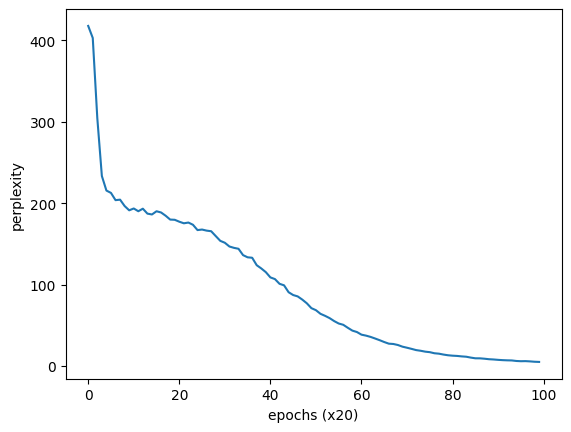

In [8]:
# chap05/train.py
%matplotlib inline
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from dataset import ptb
from simple_rnnlm import SimpleRnnlm


# Hyper-parameter settings
batch_size = 10
wordvec_size = 100
hidden_size = 100  #Number of elements in the hidden state vector of RNN
time_size = 5  #unfolding size of RNN
lr = 0.1
max_epoch = 100

# Read training data
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # Set the test dataset small
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # input
ts = corpus[1:]  # Output (correct answer label)

# Model creation
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()